# Inference on GD-1 with Gaia and PanSTARRS data

In [2]:
import hypothesis
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from sklearn.neighbors import KernelDensity
from plotting import compute_1d_profile_likelihood
from plotting import compute_2d_profile_likelihood
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_pdf_abc
from plotting import compute_2d_pdf_abc
from plotting import plot_1d_profile_likelihood
from plotting import plot_2d_profile_likelihood
from plotting import plot_1d_confidence_level
from plotting import plot_1d_confidence_levels
from plotting import plot_2d_confidence_level
from plotting import plot_2d_confidence_levels
from plotting import plot_1d_pdf
from plotting import plot_2d_pdf
from plotting import plot_1d_pdf_std
from plotting import plot_1d_contours
from plotting import plot_2d_contours
from plotting import plot_stream
from ratio_estimation import RatioEstimator
from tqdm import tqdm
from util import load_ratio_estimator

## Load the pretrained ratio estimators

In [ ]:
query = "out/coverage/4096/marginalized/selu/*ratio-estimator-resnet-50-*/best-model.th"

r_1d = load_ratio_estimator(query, normalize_inputs=False)

In [ ]:
query = "out/coverage/4096/not-marginalized/selu/*ratio-estimator-resnet-50-*/best-model.th"

r_2d = load_ratio_estimator(query, normalize_inputs=False)

## Globals

In [3]:
datadir = "../experiment-simulations/data"   # Root directory containing the generated and observed data
phi = np.load(datadir + "/phi-cut.npy")      # Linear angle

## Observed GD-1

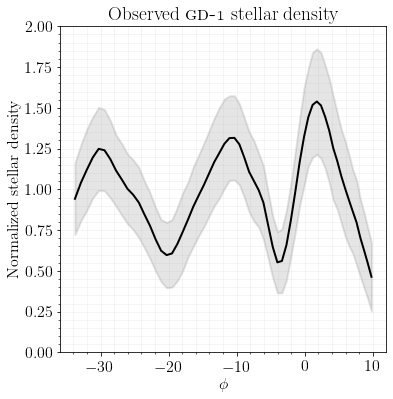

In [4]:
observed_noisy = np.load(datadir + "/observed-noised.npy")

mean_observed = np.mean(observed_noisy, axis=0)
std_observed = 2 * np.std(observed_noisy, axis=0) # 95%

figure, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.plot(phi, mean_observed, lw=2, color="black")
#for _ in range(5):
#    index = np.random.randint(0, 1000)
#    density = observed_noisy[index]
#    plt.plot(phi, density, lw=2, color="black", alpha=.25)
plt.fill_between(phi, mean_observed - std_observed, mean_observed + std_observed, lw=2, color="black", alpha=.10)
plt.ylim([0, 2])
plt.minorticks_on()
m = np.mean(observed_noisy, axis=0)
plt.title(r"Observed \textsc{gd-}\oldstylenums{1} stellar density")
plt.grid(True, which="both", alpha=.15)
plt.ylabel("Normalized stellar density")
plt.xlabel(r"$\phi$")
plt.gca().set_xticks([-30, -20, -10, 0, 10])
make_square(plt.gca())
figure.savefig("plots/gd1.pdf", bbox_inches="tight")
plt.show()

observed_noisy = torch.from_numpy(observed_noisy).float()

## Area under posterior diagnostic

In [5]:
x = np.load("out/gd1/integrand-resnet-50-marginalized.npy")

print(np.mean(x))
print(np.std(x))

0.96106652375035
0.011333328446383692


# Bayesian

### Approximate Bayesian Computation

In [262]:
paths = glob.glob("out/gd1/abc-*/samples.npy")
paths = glob.glob("test/samples.npy")
samples = []
for p in paths:
     samples.append(np.load(p).reshape(-1, 2))
posterior_samples = np.vstack(samples)

print(posterior_samples.shape)

(4, 2)


In [247]:
@torch.no_grad()
def compute_2d_pdf_abc(samples, resolution=100, bandwidth=1):
    masses = torch.linspace(1, 50 - 0.01, resolution).view(-1, 1).cpu()
    ages = torch.linspace(3, 7 - 0.01, resolution).view(-1, 1).cpu()
    grid_masses, grid_ages = torch.meshgrid(masses.view(-1), ages.view(-1))
    inputs = torch.cat([grid_masses.reshape(-1,1), grid_ages.reshape(-1, 1)], dim=1)
    inputs = inputs.view(-1, 2).numpy()
    # Prepare the posterior samples
    samples = samples.reshape(-1, 2)
    # Fit a kernel
    kernel = KernelDensity(kernel="epanechnikov", bandwidth=bandwidth).fit(samples)
    pdf = np.exp(kernel.score_samples(inputs)).reshape(resolution, resolution)

    return pdf

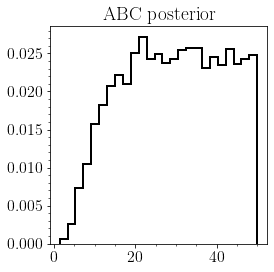

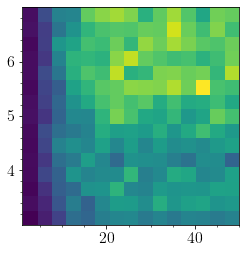

[9.74906845 3.29568911] keV Gyr (95% CI)


In [254]:
p = posterior_samples[:, 0]
kernel = KernelDensity(kernel="epanechnikov", bandwidth=1).fit(p.reshape(-1, 1))
inputs = np.linspace(1, 50, 100).reshape(-1, 1)
pdf = np.exp(kernel.score_samples(inputs))
y, x, _ = plt.hist(p, bins=25, density=True, color="black", lw=2, histtype="step")
plt.minorticks_on()
plt.title("ABC posterior")

space = np.linspace(1, 50, 100)
make_square(plt.gca())
plt.show()

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=15, density=True)
plt.xlim([1, 50])
make_square(plt.gca())
plt.minorticks_on()
plt.show()

print(np.percentile(posterior_samples, 5, axis=0), "keV Gyr (95% CI)")

In [257]:
pdf = compute_2d_pdf_abc(posterior_samples, bandwidth=0.5)

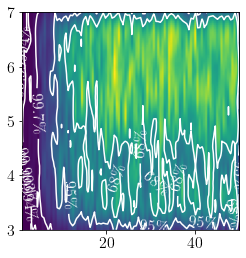

In [258]:
extent = [ # I know, this isn't very nice :(
    1, 50,
    3, 7]

plt.imshow(pdf.T, origin="lower", extent=extent)
plot_2d_contours(plt.gca(), pdf)
make_square(plt.gca())
plt.show()

### GD-1 posteriors

#### Marginalized over the stream age

In [ ]:
pdf_mean_1d, pdf_std_1d = compute_1d_pdf(r_1d, observed_noisy, median=False)

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_1d_contours(ax, pdf_mean_1d)
plot_1d_pdf(ax, pdf_mean_1d)
ax.fill_between(np.linspace(1, 50, 100), pdf_mean_1d - pdf_std_1d, pdf_mean_1d + pdf_std_1d, color="black", alpha=.1)
x = np.linspace(1, 50, 100)
ax.set_ylabel("Posterior density")
ax.set_title(r"Marginalized \textsc{gd-}\oldstylenums{1} posterior")
ylim = ax.get_ylim()
ax.text(25, (ylim[0] + ylim[1]) / 2, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="black", alpha=.5, size=30, ha="center", va="center", zorder=1)
make_square(ax)
figure.tight_layout()
figure.savefig("plots/posterior-gd1-1d.pdf", bbox_inches="tight")
figure.show()

#### Posterior over the stream age and the mass

In [ ]:
pdf_mean_2d, pdf_std_2d = compute_2d_pdf(r_2d, observed_noisy, median=False)

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(6, 6))
p = pdf_mean_2d 
plot_2d_contours(ax, p)
plot_2d_pdf(ax, p)
ax.set_title(r"Full \textsc{gd-}\oldstylenums{1} posterior")
ax.text(25, 5, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="white", alpha=.5, size=30, ha="center", va="center", zorder=1)
figure.tight_layout()
figure.savefig("plots/posterior-gd1-2d.pdf", bbox_inches="tight")
figure.show()

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_2d_pdf(ax, np.log(1 + pdf_std_2d))
ax.set_title(r"Full \textsc{gd-}\oldstylenums{1} posterior variability")
ax.text(25, 5, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="white", alpha=.5, size=30, ha="center", va="center", zorder=1)
figure.tight_layout()
figure.savefig("plots/posterior-gd1-2d-std.pdf", bbox_inches="tight")
figure.show()

### Joint plot

#### Wide

In [ ]:
figure, axes = plt.subplots(1, 3, figsize=(18, 6))

# Stream
ax = axes[0]
mean = np.mean(observed_noisy.numpy(), axis=0)
std = np.std(observed_noisy.numpy(), axis=0)
ax.plot(phi, mean, color="black", lw=2)
ax.fill_between(phi, mean - std, mean + std, color="black", alpha=.1)
ax.set_ylabel("Normalized density contrast")
ax.set_title(r"Observed \textsc{gd-}\oldstylenums{1} data")
ax.minorticks_on()
ax.set_xticks([-30, -20, -10, 0, 10])
ax.set_xlabel(r"$\phi$")
# Marginalized (1D)
ax = axes[1]
plot_1d_contours(ax, pdf_mean_1d)
plot_1d_pdf(ax, pdf_mean_1d)
ax.fill_between(np.linspace(1, 50, 100), pdf_mean_1d - pdf_std_1d, pdf_mean_1d + pdf_std_1d, color="black", alpha=.1)
ylim = ax.get_ylim()
ax.text(25, (ylim[0] + ylim[1]) / 2, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="black", alpha=.5, size=30, ha="center", va="center", zorder=1)
ax.set_ylabel("Posterior density")
ax.set_title(r"Marginalized \textsc{gd-}\oldstylenums{1} posterior")
# Not marginalized (2D)
ax = axes[2]
ax.text(25, 5, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="white", alpha=.5, size=30, ha="center", va="center", zorder=1)
plot_2d_contours(ax, pdf_mean_2d)
plot_2d_pdf(ax, pdf_mean_2d)
ax.set_title(r"Full \textsc{gd-}\oldstylenums{1} posterior")

figure.tight_layout()
figure.savefig("plots/posterior-gd1-joint.pdf", bbox_inches="tight")
figure.show()

#### Short

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(12, 6))

# Marginalized (1D)
ax = axes[0]
plot_1d_contours(ax, pdf_mean_1d)
plot_1d_pdf(ax, pdf_mean_1d)
ax.fill_between(np.linspace(1, 50, 100), pdf_mean_1d - pdf_std_1d, pdf_mean_1d + pdf_std_1d, color="black", alpha=.1)
ylim = ax.get_ylim()
ax.text(25, (ylim[0] + ylim[1]) / 2, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="black", alpha=.5, size=30, ha="center", va="center", zorder=1)
ax.set_ylabel("Posterior density")
ax.set_title(r"Marginalized \textsc{gd-}\oldstylenums{1} posterior")
make_square(ax)

# Not marginalized (2D)
ax = axes[1]
ax.text(25, 5, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="white", alpha=.5, size=30, ha="center", va="center", zorder=1)
plot_2d_contours(ax, pdf_mean_2d)
plot_2d_pdf(ax, pdf_mean_2d)
ax.set_title(r"Full \textsc{gd-}\oldstylenums{1} posterior")
make_square(ax)

figure.tight_layout()
figure.savefig("plots/posterior-gd1-joint-short.pdf", bbox_inches="tight")
figure.show()

## Frequentist

### GD-1 Profile Likelihood

#### Marginalized over the stream age

In [ ]:
profile_likelihood_1d, std = compute_1d_profile_likelihood(r_1d, observed_noisy, median=False)

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_1d_profile_likelihood(ax, profile_likelihood_1d)
plot_1d_confidence_levels(ax, profile_likelihood_1d)
ax.fill_between(np.linspace(1, 50, 100), profile_likelihood_1d - std, profile_likelihood_1d + std, color="black", alpha=.1)
ylim = ax.get_ylim()
ax.text(25, (ylim[0] + ylim[1]) / 2, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="black", alpha=.5, size=30, ha="center", va="center", zorder=1)
ax.set_title(r"\textsc{gd-}\oldstylenums{1} likelihood ratio test-statistic")
make_square(ax)
figure.tight_layout()
figure.savefig("plots/profile-likelihood-gd1-1d.pdf", bbox_inches="tight")
figure.show()

#### Full profile likelihood over the stream age and the mass

In [ ]:
profile_likelihood_2d, _ = compute_2d_profile_likelihood(r_2d, observed_noisy, median=False)

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_2d_profile_likelihood(ax, profile_likelihood_2d)
plot_2d_confidence_levels(ax, profile_likelihood_2d)
ax.set_title(r"\textsc{gd-}\oldstylenums{1} likelihood ratio test-statistic")
ax.text(25, 5, r"\textsc{preliminary result}", rotation_mode="anchor", rotation=-35.0, color="black", alpha=.5, size=30, ha="center", va="center", zorder=1)
make_square(ax)
figure.tight_layout()
figure.savefig("plots/profile-likelihood-gd1-2d.pdf", bbox_inches="tight")
figure.show()